# Imports

In [1]:
import h5py
import os
import cv2
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
import numpy as np
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading nifti images
import math
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from read_data import load_images
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Dependencies

In [80]:
import tensorflow as tf
import keras
print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

Tensorflow version: 1.5.0
Keras version: 2.2.4


# Data Preprocessing
Prepare data for input and data preprocessing

In [12]:
def three_to_two(path, label='FALSE'):
    ff = glob.glob(path)
    images =[]
    for f in range(len(ff)):
        a = nib.load(ff[f])
        a = a.get_data()
        for i in range(a.shape[2]):
            images.append(a[:,:,i])     
    images = np.asarray(images)
    #images = images.reshape(-1, 128,128, 1) # dimension to feed into the network
    return images

def min_max_norm(images):
    m = np.max(images)
    mi = np.min(images)
    images = (images - mi)/ (m - mi)
    return images

def label_outliers(img_labels):
    img_labels[img_labels>1]=1
    img_labels[img_labels<0]=0
    return img_labels

#Image for training 
images = three_to_two(path='img_new/*')
x_data = min_max_norm(images)
#x_data = images

#labels
img_labels = three_to_two(path='img_new_label/*')
y_data = label_outliers(img_labels)
#y_data = img_labels

Plot data w.r.t labels

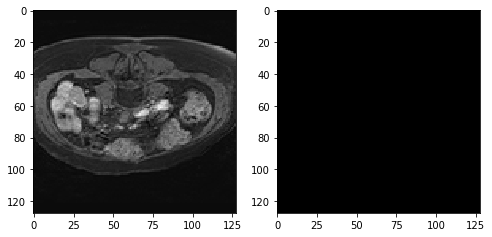

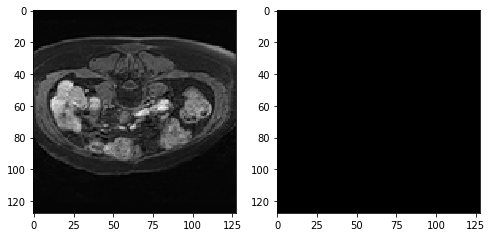

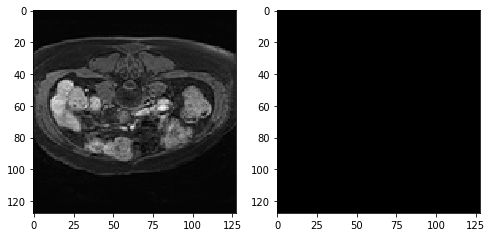

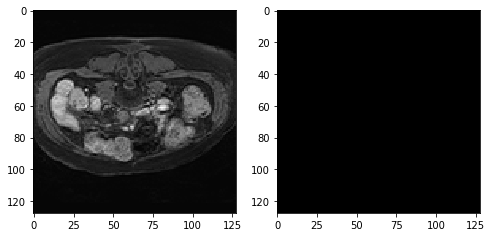

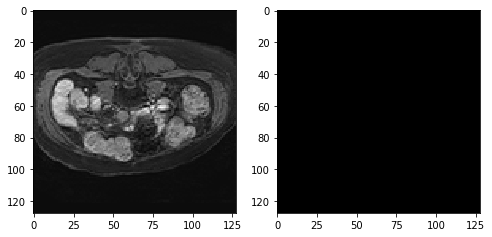

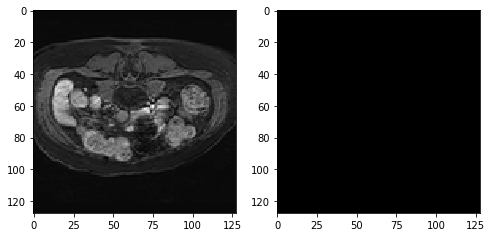

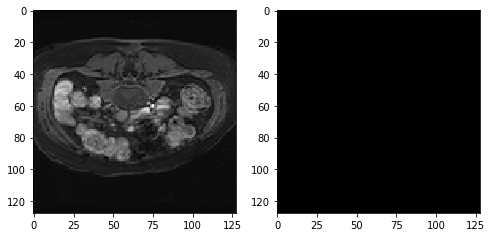

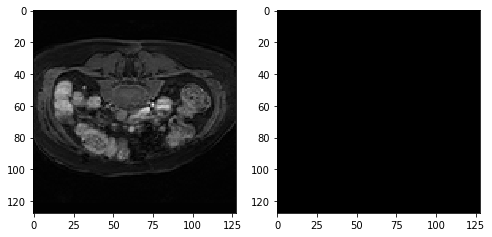

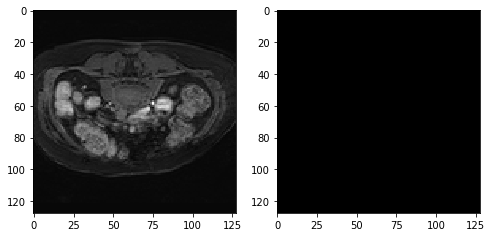

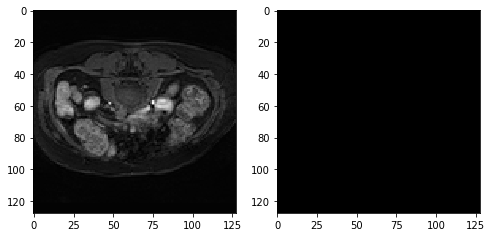

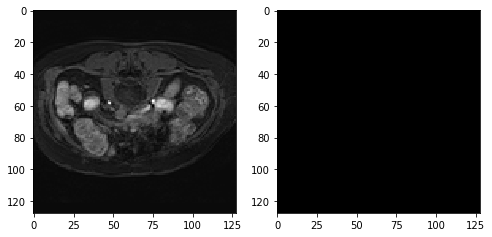

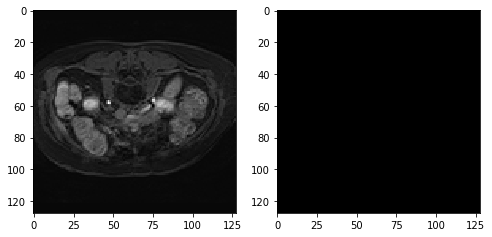

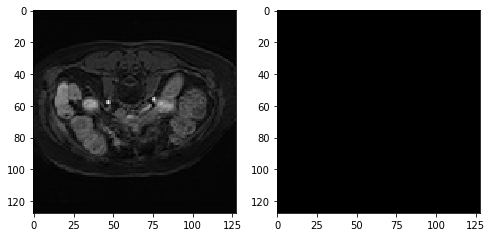

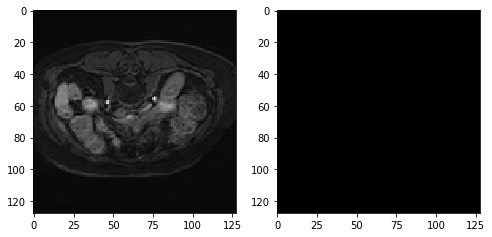

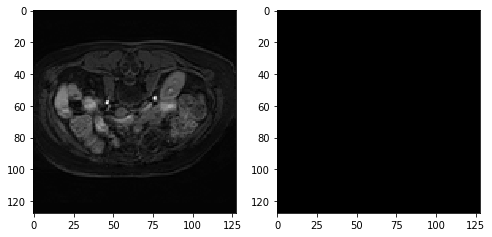

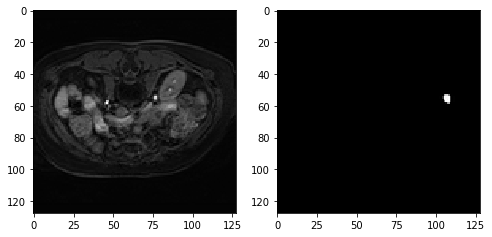

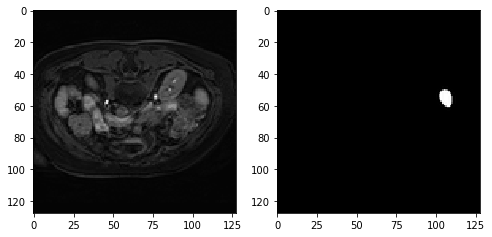

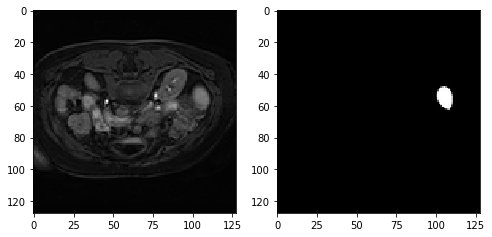

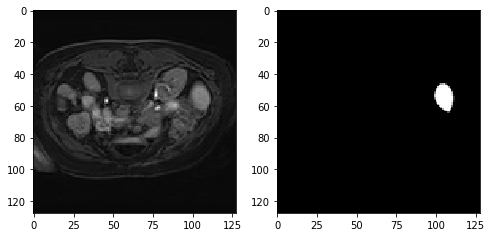

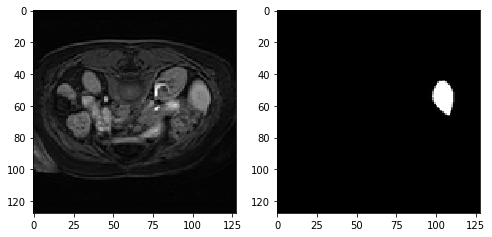

In [17]:
#show 1st 20 slices

for i in range(20):
    fig, ax = plt.subplots(1,2, figsize = (8,4))
    ax[0].imshow(x_data[i], cmap='gray')
    ax[1].imshow(y_data[i], cmap='gray')
    
plt.show()

Reshape input data to feed into the network with 
shape (depth*#image, width, height, channel)

In [18]:
x_data = x_data[:,:,:,np.newaxis] # same as reshape (-1,128,128,1)
y_data = y_data[:,:,:,np.newaxis]

print(x_data.shape)
print(y_data.shape)

(3036, 128, 128, 1)
(3036, 128, 128, 1)


Split data: 80% Training, 20% Validation

In [19]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.2)

Approximation of Dice Coefficient

In [20]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [36]:
input_layer = Input(shape=x_train.shape[1:]) #Input(shape = (x, y, inChannel))

# Network Topology

Toy Model 01 

In [38]:
def Unet_01(input_layer):
    c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
    l = MaxPooling2D(strides=(2,2))(c1)
    c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
    l = MaxPooling2D(strides=(2,2))(c2)
    c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
    l = MaxPooling2D(strides=(2,2))(c3)
    c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
    l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
    l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
    l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
    l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
    l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
    l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
    l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
    l = Dropout(0.5)(l)
    output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)

    model = Model(input_layer, output_layer)
    return model

Toy Model 02

In [42]:
def Unet_02(input_layer, k_size=(3,3)):
    merge_axis = -1 # Feature maps are concatenated along last axis (for tf backend)
    conv1 = Conv2D(filters=32, kernel_size=k_size, padding='same', activation='relu')(input_layer)
    conv1 = Conv2D(filters=32, kernel_size=k_size, padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(pool1)
    conv2 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(pool2)
    conv3 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(pool3)
    conv4 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(pool4)

    up1 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(up1)
    conv6 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(conv6)
    merged1 = concatenate([conv4, conv6], axis=merge_axis)
    conv6 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(merged1)

    up2 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(up2)
    conv7 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(conv7)
    merged2 = concatenate([conv3, conv7], axis=merge_axis)
    conv7 = Conv2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(merged2)

    up3 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(up3)
    conv8 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(conv8)
    merged3 = concatenate([conv2, conv8], axis=merge_axis)
    conv8 = Conv2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(merged3)

    up4 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(up4)
    conv9 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv9)
    merged4 = concatenate([conv1, conv9], axis=merge_axis)
    conv9 = Conv2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(merged4)

    conv10 = Conv2D(filters=1, kernel_size=k_size, padding='same', activation='sigmoid')(conv9)
    output_layer = conv10
    
    model = Model(input_layer, output_layer)
    return model

Swtich for different network

In [43]:
#model = Unet_01(input_layer)
model = Unet_02(input_layer)

Data Augmentation

In [44]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=42)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=42)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

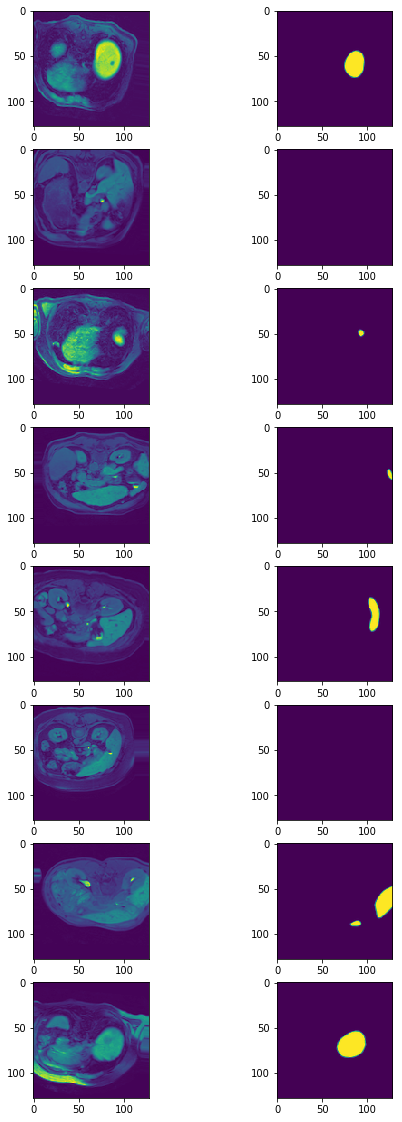

In [25]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [45]:
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])

In [46]:
from keras.callbacks import LearningRateScheduler
weight_saver = ModelCheckpoint('seg.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

Parameters

In [52]:
batch_size = 128
epochs = 50

# Training

In [53]:
hist = model.fit_generator(my_generator(x_train, y_train, batch_size),
                           steps_per_epoch = 200,
                           validation_data = (x_val, y_val),
                           epochs=epochs, verbose=2,
                           callbacks = [weight_saver, annealer])

Epoch 1/50
 - 166s - loss: 0.1459 - dice_coef: 0.2846 - val_loss: 0.1383 - val_dice_coef: 0.3163
Epoch 2/50
 - 158s - loss: 0.1332 - dice_coef: 0.3315 - val_loss: 0.1266 - val_dice_coef: 0.4051
Epoch 3/50
 - 157s - loss: 0.1121 - dice_coef: 0.4374 - val_loss: 0.0948 - val_dice_coef: 0.5691
Epoch 4/50
 - 158s - loss: 0.0744 - dice_coef: 0.6321 - val_loss: 0.0626 - val_dice_coef: 0.7084
Epoch 5/50
 - 166s - loss: 0.0507 - dice_coef: 0.7512 - val_loss: 0.0490 - val_dice_coef: 0.7862
Epoch 6/50
 - 156s - loss: 0.0381 - dice_coef: 0.8138 - val_loss: 0.0422 - val_dice_coef: 0.8215
Epoch 7/50
 - 155s - loss: 0.0312 - dice_coef: 0.8471 - val_loss: 0.0365 - val_dice_coef: 0.8503
Epoch 8/50
 - 154s - loss: 0.0271 - dice_coef: 0.8674 - val_loss: 0.0327 - val_dice_coef: 0.8649
Epoch 9/50
 - 154s - loss: 0.0243 - dice_coef: 0.8809 - val_loss: 0.0328 - val_dice_coef: 0.8711
Epoch 10/50
 - 152s - loss: 0.0222 - dice_coef: 0.8913 - val_loss: 0.0302 - val_dice_coef: 0.8819
Epoch 11/50
 - 152s - loss: 0

In [55]:
model.load_weights('seg.h5')

# Results  

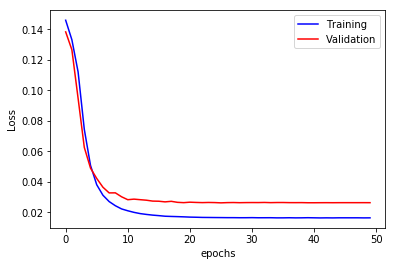

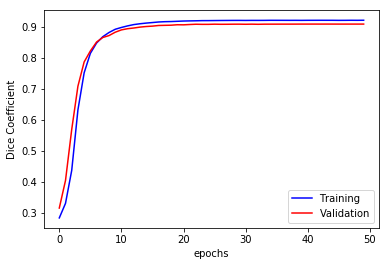

In [75]:
plt.plot(hist.history['loss'], color='b', label='Training')
plt.plot(hist.history['val_loss'], color='r', label='Validation')
plt.legend(loc='upper right')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(hist.history['dice_coef'], color='b', label='Training')
plt.plot(hist.history['val_dice_coef'], color='r', label='Validation')
plt.xlabel("epochs")
plt.ylabel("Dice Coefficient")
plt.legend(loc='lower right')
plt.show()

# Prediction

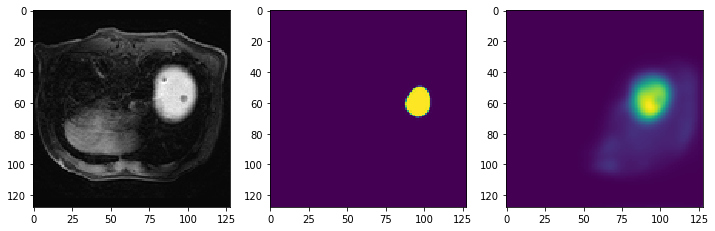

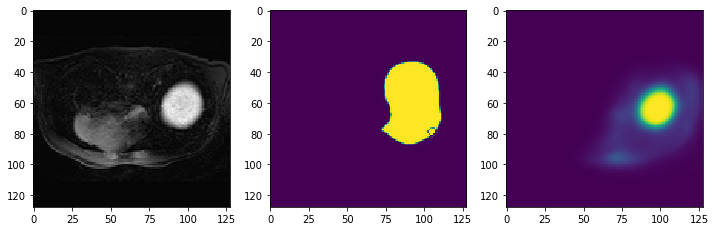

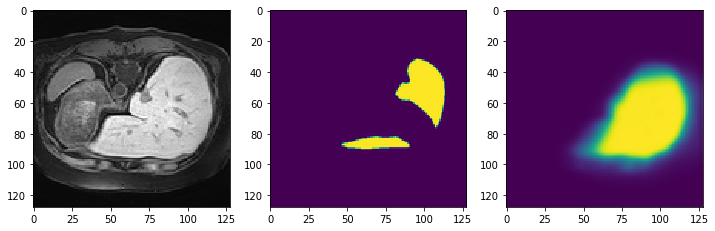

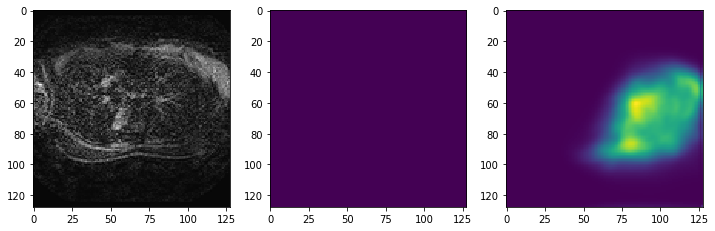

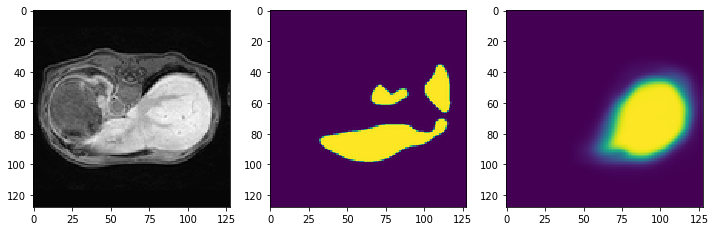

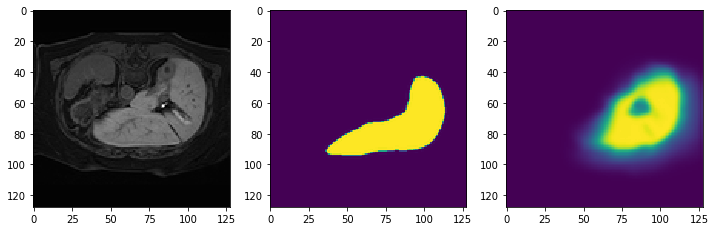

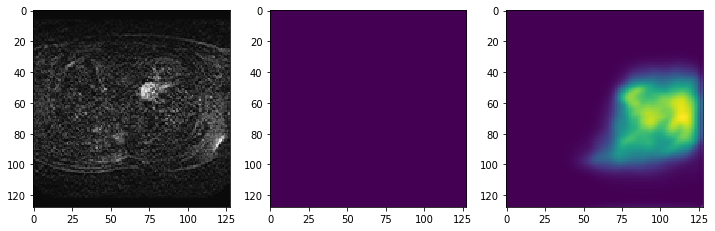

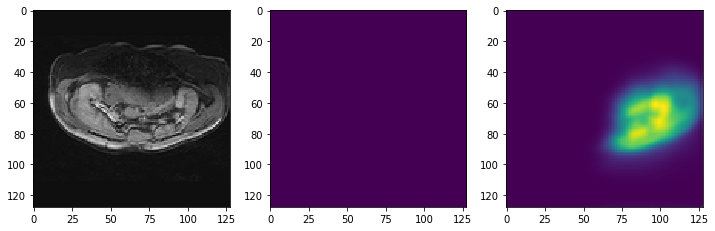

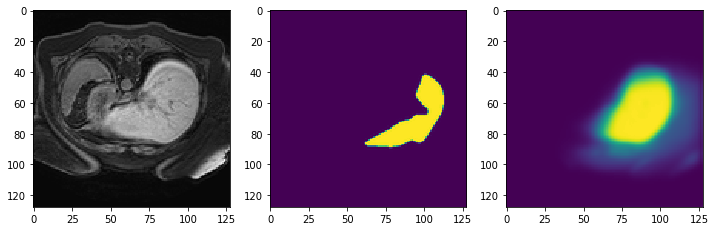

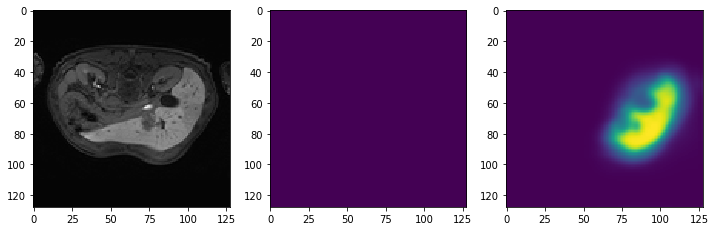

In [64]:
y_pred = model.predict(x_val)
for i in range(10):
    fig, ax = plt.subplots(1,3,figsize=(12,6))
    ax[0].imshow(x_val[i,:,:,0], cmap='gray')
    ax[1].imshow(y_val[i,:,:,0])
    ax[2].imshow(y_pred[i,:,:,0])

plt.show()

# Appendix

In [65]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 128, 128, 32) 9248        conv2d_21[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_22[0][0]                  
__________________________________________________________________________________________________
conv2d_23 

# Reference

https://www.kaggle.com/toregil/a-lung-u-net-in-keras